In [3]:
import pandas as pd 
import numpy as np
from src.download import *
import zipfile 
import glob
from tqdm import tqdm  
import os
from src.files.fasta import FASTAFile
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score, completeness_score
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import re
import subprocess
import math 
from utils import * 
from src.data import *
import matplotlib.cm 
import matplotlib.colors

%load_ext autoreload
%autoreload 2


niks_domain = 'NIKS'
ycf_domain = 'Y.C'

In [4]:
conservation_threshold = 0.8 # Flag conserved positions as those where at least 80 percent of the sequences do not have a gap. 
is_conserved = lambda col : (col != '-').astype(int).mean() > conservation_threshold

In [5]:
arf1_df = pd.read_csv('../data/arf1_cleaned.csv', index_col=0)
index, alignment = load_msa(path='../data/arf1_cleaned.afa', ids=arf1_df.index)
print('Num. aligned sequences:', len(alignment))

conserved_positions = np.where([is_conserved(col) for col in alignment.T])[0]
print('Num. conserved positions:', len(conserved_positions))

alignment = alignment[:, conserved_positions] # Ignore the extra junk in the alignment. 

seq = ''.join(alignment[0]) # The first entry in the alignment has the canonical NIKS domain and YXCXXXF.
ycf_match = re.search(ycf_domain, seq)
start, stop = ycf_match.start(), ycf_match.end()

alignment_df = pd.DataFrame(alignment, index=index)
alignment_df['group'] = np.where(arf1_df.has_pyl, 'pyl', 'no_pyl')

# There are like 2 cases where the C is not conserved, which seems to be skewing the MI plot.
keep_idxs = np.where(alignment[:, 121].ravel() == 'C')[0]
alignment = alignment[keep_idxs, :].copy() 
# np.unique(alignment[:, 121].ravel(), return_counts=True)
# np.unique(alignment[:, 119].ravel(), return_counts=True)

Num. aligned sequences: 2803
Num. conserved positions: 408


In [6]:
# if not os.path.exists('../data/mutual_information.txt'):
#     h = mutual_information(alignment)
#     h[h == 1] = np.nan
#     with open('../data/mutual_information.txt', 'w') as f:
#         np.savetxt(f, h)
# else:
#     with open('../data/mutual_information.txt', 'r') as f:
#         h = np.loadtxt(f)

with open('../data/mutual_information_no_outliers.txt', 'r') as f:
    h = np.loadtxt(f)

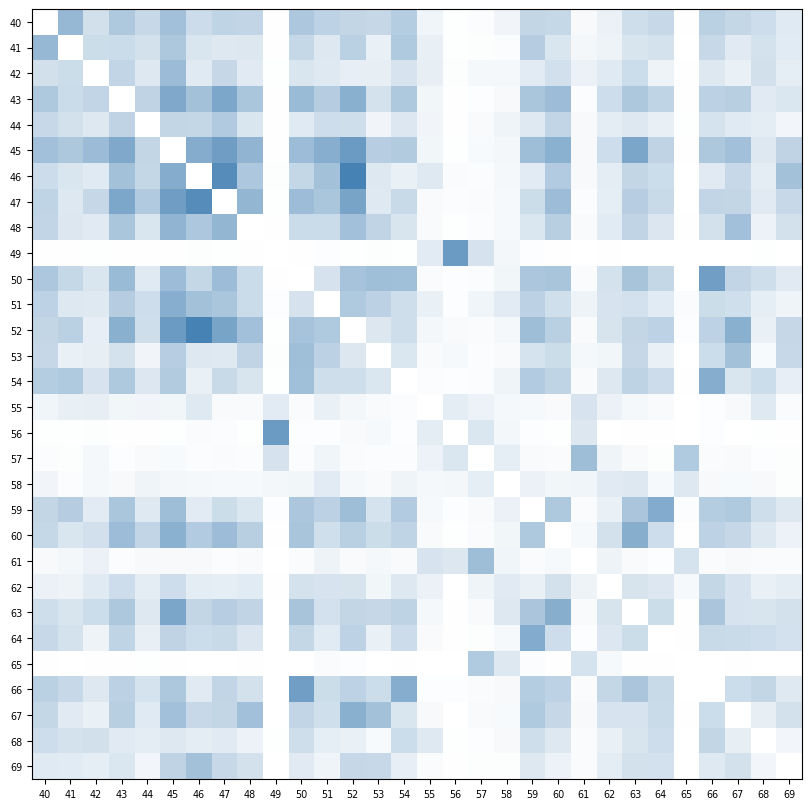

In [7]:
def figure(h:np.ndarray, start=40, stop=70):
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('palette', ['white', 'steelblue'])

    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(h[start:stop, start:stop], cmap=cmap)
    ax.set_xticks(np.arange(stop - start), labels=np.arange(start, stop), fontsize='x-small')
    ax.set_yticks(np.arange(stop - start), labels=np.arange(start, stop), fontsize='x-small')
    plt.show()

figure(h)

In [8]:
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list('palette', ['white', 'steelblue'])
# positions = np.array([52, 67, 70, 74])

# start, stop = 50, 90
# fig, ax = plt.subplots(figsize=(8, 10))
# plt.imshow(h[positions, start:stop], cmap=cmap)
# ax.set_yticks(np.arange(len(positions)), labels=positions, fontsize='x-small')
# ax.set_xticks(np.arange(stop - start), labels=np.arange(start, stop), fontsize='x-small')
# plt.show()

In [9]:
def figure_1(alignment:np.ndarray, start:int=None, stop:int=None, delta:int=0, highlight:tuple=None, ax:plt.Axes=None, color:str='steelblue', label=None, scale:np.ndarray=None, threshold:float=np.inf, annotate_residues:bool=False):

    alignment = alignment[:, start - delta:stop + delta].copy() # start - delta is the new zero. 
    offset = (start - delta)

    most_common_symbols, _ = get_entropies(alignment) # Need to get the most common symbols before applying the substitution matrix. 

    for aa, symbol in dayhoff.items():
        alignment[alignment == aa] = symbol

    _, entropies = get_entropies(alignment)
    entropies = entropies / entropies.max()
    entropies = entropies - scale if (scale is not None) else entropies

    sns.lineplot(x=np.arange(len(entropies)), y=entropies, ax=ax)

    x_ticks = np.where((entropies < -threshold) | (entropies > threshold))[0] # Mark all positions below a certain threshold.
    sns.lineplot(x=np.arange(len(entropies)), y=entropies, ax=ax, color=color, label=label)
    ax.set_xlim(xmin=0, xmax=len(entropies))
    ax.set_xticks(x_ticks, labels=x_ticks + offset, fontsize='xx-small', rotation=90)
    ax.set_ylabel('entropy')
    
    if annotate_residues:
        for x, symbol in enumerate(most_common_symbols):
            ax.text(x, ax.get_ylim()[-1], symbol, ha='center', va='bottom', fontsize='xx-small')

    if highlight is not None:
        x_min, x_max = highlight
        ax.axvspan(x_min - offset, x_max - offset, alpha=0.2, color=color)

    return np.arange(len(entropies)) + offset, entropies


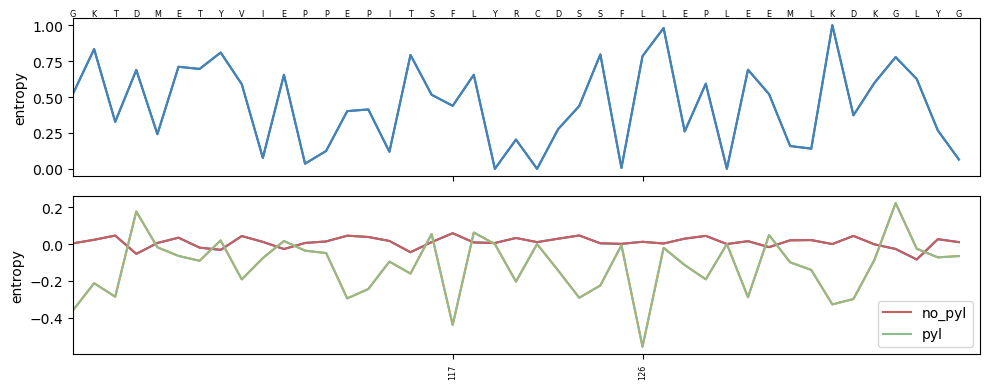

In [10]:
palette = {'pyl':'darkseagreen', 'no_pyl':'indianred'}

fig, axes = plt.subplots(figsize=(10, 4), nrows=2, sharex=True)

_, entropies = figure_1(alignment, start=start, stop=stop, delta=20, ax=axes[0], threshold=0.2, annotate_residues=True)

scaled_entropies = dict()
for group, df in alignment_df.groupby('group'):
    positions, scaled_entropies[group] = figure_1(df.values, start=start, delta=20, stop=stop, color=palette[group], ax=axes[1], label=group, scale=entropies, threshold=0.4)

axes[1].legend()
fig.tight_layout()

fig.savefig('../figure_1_niks.png', format='PNG', dpi=600)
plt.show()

In [11]:
def figure_2(alignment_df:pd.DataFrame, position:int=None, palette={'pyl':'darkseagreen', 'no_pyl':'indianred'}, ax=None, legend:bool=True):
    figure_df = alignment_df[['group', position]].copy()
    sns.histplot(figure_df, x=position, hue='group', multiple='dodge', ax=ax, palette=palette, legend=legend)
    ax.set_ylabel('count')
    # ax.set_yscale('log')
    if legend:
        ax.get_legend().set_title('')
    ax.set_xlabel('')
    ax.set_title(f'position {position}')

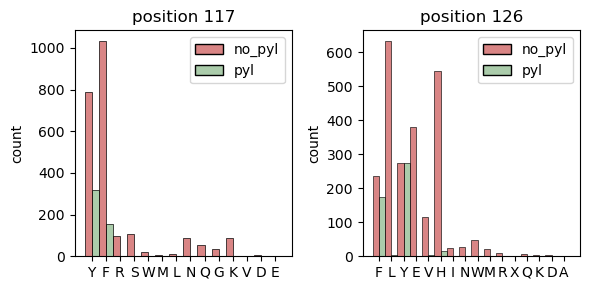

In [12]:
positions = [117, 126]
fig, axes = plt.subplots(ncols=len(positions), figsize=(3 * len(positions), 3))
for ax, position in zip(axes.ravel(), positions):
    figure_2(alignment_df, position=position, ax=ax)
fig.tight_layout()
plt.show()

# Q is glutamine, polar and uncharged. 
# S is serine, polar and uncharged. 
# A is alanine, small and hydrophobic. 
# T is threonine, polar and uncharged. 
# E is glutamic acid, which is negatively-charged. 

# Glutamine can generate stronger hydrogen bonds than serine. 

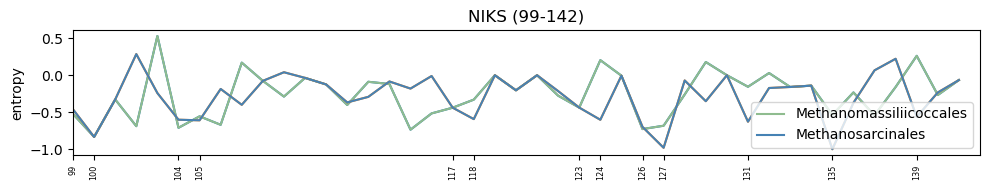

In [13]:
palette = {'Methanosarcinales':'steelblue', 'Methanomassiliicoccales':'darkseagreen'}

figure_df = alignment_df.copy()
figure_df['group'] = arf1_df['order'].values
figure_df = figure_df[arf1_df.has_pyl].copy()
figure_df['group'] = np.where(~figure_df['group'].isin(palette.keys()), 'other', figure_df['group'])
figure_df = figure_df[figure_df.group != 'other'].copy()

delta = 20
fig, ax = plt.subplots(figsize=(10, 2))
for group, df in figure_df.groupby('group'):
    figure_1(df.values, start=start, stop=stop, color=palette.get(group, 'gray'), ax=ax, delta=delta, label=group, threshold=0.4, scale=entropies)
ax.set_title(f'NIKS ({start - delta}-{stop + delta})')
# ax.axhline(1, color='gray', ls='--', lw=0.7)
# ax.set_ylim(ymax=1, ymin=0)
fig.tight_layout()
plt.show()

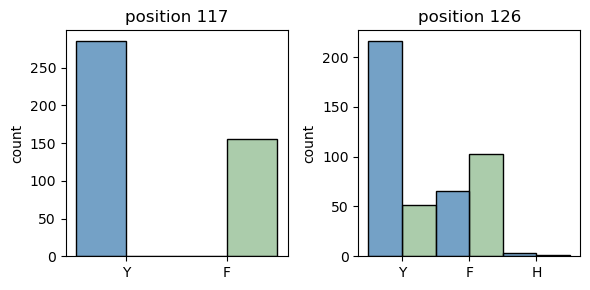

In [16]:
palette = {'Methanosarcinales':'steelblue', 'Methanomassiliicoccales':'darkseagreen'}
positions = [117, 126]
fig, axes = plt.subplots(ncols=len(positions), figsize=(3 * len(positions), 3))
for ax, position in zip(axes.ravel(), positions):
    figure_2(figure_df, position=position, ax=ax, palette=palette, legend=False)
fig.tight_layout()
plt.show()

In [15]:
pyl_idxs = np.where(arf1_df.has_pyl)[0]
no_pyl_idxs = np.where(~arf1_df.has_pyl)[0]

pyl_alignment = alignment[pyl_idxs].copy()
no_pyl_alignment = alignment[no_pyl_idxs].copy()

positions = [67, 70, 74]

pyl_alignment = [''.join(residues) for residues in pyl_alignment[:, positions]]
no_pyl_alignment = [''.join(residues) for residues in no_pyl_alignment[:, positions]]

IndexError: index 2801 is out of bounds for axis 0 with size 2801

In [ ]:
seq = alignment[pyl_idxs[0]] # [positions]
seq = ''.join(seq)
seq

'MTEQSAHEKYEFKKKLESLRDKKGRSTELISLYIPADKQIFDVTNQLKDEHGQAANIKSKLTRTNVQGAIESLLSRLRYLDKVPENGIVYFTGAVDIGANKTSMESEVIIPPEPITVYKYHCDSSFYLEPLEDMLKDKSTFGLLVLDRREATIGLLVGKRIQAFRNLTSTVPGKQRKGGQSAHRFQQLRLIAIHDFYKRIGDAASEIFMAVKDLKGVLIGGPSPTKEEFYGGEFLHHELQKKILGLFDTAYTDESGLSELVNAAGEKLQDLELMGQKNAVRDFFKELIASGKVAYGETQVRANLEINAVDVLLLSEDLRAERVTTKCSVCGYENKWTRRWKAPTAGNCPKCGSSLEVTDVIDVVDEFSELADKSNAKVVFVSTDFDEGSQLMNAFGGIAAILRYSTV*'

In [ ]:
kmers, counts = np.unique(pyl_alignment, return_counts=True)
kmers = kmers[np.argsort(counts)[::-1]]
counts = np.sort(counts)[::-1]

for kmer, count in zip(kmers, counts):
    print(count, kmer)

216 GES
79 GEA
44 SDS
39 GDS
38 SDA
19 GDA
6 GQA
5 NVQ
4 DVQ
4 SDG
3 SVQ
3 SEQ
3 SES
2 SEA
1 STQ
1 NEA
1 NEN
1 SDQ
1 GSS
1 EHA
1 DEQ
1 AEQ


In [ ]:
kmers, counts = np.unique(no_pyl_alignment, return_counts=True)
kmers = kmers[np.argsort(counts)[::-1]]
counts = np.sort(counts)[::-1]

for kmer, count in zip(kmers, counts):
    print(count, kmer)

397 DTD
197 SSS
134 GES
114 DTQ
109 DGQ
93 DEQ
88 DVQ
76 GEQ
72 SES
71 DSQ
68 SEQ
67 DKD
59 WEG
55 SSA
52 AES
40 DSE
38 SEA
26 DES
22 DSG
20 GEN
20 AEQ
19 DSA
19 ASS
19 DEA
15 QEQ
14 SDQ
14 DEN
14 DTE
14 GDQ
13 DSS
13 DEH
11 GDS
11 SDS
10 EVQ
10 AEN
9 WDG
9 STA
8 AEA
8 WEN
8 DGS
7 NEQ
7 EEQ
6 DAN
6 DGR
6 SEN
6 GSA
6 ETQ
6 SDA
5 GRG
5 WDN
5 DIQ
5 ADR
5 ASN
5 ADQ
5 DTA
5 DAG
5 GRN
5 EEN
5 GKN
5 GQA
4 SRG
4 DVE
4 AKQ
4 DAQ
4 GAQ
4 QES
3 DNG
3 GEA
3 NAA
3 GTA
3 TEQ
3 TEN
3 DQQ
3 ATA
3 DKQ
3 DTG
3 DDQ
3 ARS
3 SEG
3 AAN
2 DMQ
2 DNE
2 ADN
2 AEH
2 TER
2 SSD
2 QEN
2 AQA
2 GSS
2 GET
2 SDR
2 GEG
2 SER
2 SKN
2 SEH
2 SDG
2 GAS
2 NTE
2 NEG
2 QTA
2 DAA
2 DEG
2 ARN
2 EEG
2 GER
2 GEH
1 SNG
1 SQA
1 SKQ
1 SNA
1 SRS
1 TDR
1 STQ
1 XES
1 TGQ
1 TES
1 SQG
1 SQS
1 SAQ
1 GQQ
1 EDQ
1 EDN
1 EES
1 EKQ
1 ETH
1 ESG
1 ERQ
1 GDH
1 GMQ
1 GNN
1 GDN
1 GKA
1 NEN
1 NGQ
1 QDS
1 DRA
1 DGE
1 DQA
1 DTK
1 DVD
1 DTN
1 DSN
1 DRD
1 DAS
1 ASA
1 ASQ
1 DDN
1 AQG
1 AKS
1 AQV
1 AQS
1 AAV


In [ ]:
methanosarcinales_idxs = np.where(arf1_df['order'] == 'Methanosarcinales')[0]
methanosarcinales_pyl_idxs = np.where((arf1_df['order'] == 'Methanosarcinales') & (arf1_df.has_pyl))[0]
methanomassiliicoccales_idxs = np.where(arf1_df['order'] == 'Methanomassiliicoccales')[0]
methanomassiliicoccales_pyl_idxs = np.where((arf1_df['order'] == 'Methanomassiliicoccales') & arf1_df.has_pyl)[0]

def print_kmers(idxs, positions=positions, alignment=alignment):
    alignment = alignment[idxs, :].copy()

    alignment = [''.join(residues) for residues in alignment[:, positions]]

    kmers, counts = np.unique(alignment, return_counts=True)
    kmers = kmers[np.argsort(counts)[::-1]]
    counts = np.sort(counts)[::-1]

    for kmer, count in zip(kmers, counts):
        print(count, kmer)

print_kmers(methanosarcinales_pyl_idxs)

215 GES
28 GDS
19 SDS
14 GEA
4 GDA
2 SES
1 NEA
1 GSS
1 EHA


In [ ]:
print_kmers(methanomassiliicoccales_pyl_idxs)

65 GEA
38 SDA
25 SDS
11 GDS
7 GDA
6 GQA
1 SEA
1 SDQ
1 GES


In [ ]:
table_5_metadata_df = load_kivenson_table_5_metadata()
table_5_metadata_df.sort_values('category 1')
recoded_genome_ids = table_5_metadata_df[table_5_metadata_df['category 1'] > 30].index.values
recoded_genome_idxs = np.where(arf1_df.genome_id.isin(recoded_genome_ids))[0]

print_kmers(recoded_genome_idxs)

9 GDS
3 SDS
3 GEA
3 GES
2 GDA
1 SEA


In [ ]:
table_5_metadata_df.loc[recoded_genome_ids]

,filename,ncbi_taxonomy,gtdb_taxonomy,genome,tag_percent,category 1,category 2,category 3,category 4,order,genus
accession,,,,,,,,,,,
GCA_000013725.1,GCA_000013725.1_ASM1372v1_cds_from_genomic.fna,Methanococcoides,o__Methanosarcinales; f__Methanosarcinaceae,Methanococcoides_burtonii_DSM_6242,3.79,56.52,20.29,20.29,2.90,Methanosarcinales,none
GCA_021184045.1,GCA_021184045.1_ASM2118404v1_cds_from_genomic.fna,Methanococcoides,o__Methanosarcinales; f__Methanosarcinaceae,Methanococcoides_orientis_str_LMO_1,1.78,74.36,15.38,10.26,0.00,Methanosarcinales,none
GCA_000970325.1,GCA_000970325.1_ASM97032v1_cds_from_genomic.fna,Methanococcoides,o__Methanosarcinales; f__Methanosarcinaceae,Methanococcoides_methylutens_MM1_chromosome_co...,1.59,73.33,16.67,10.00,0.00,Methanosarcinales,none
GCA_000196655.1,GCA_000196655.1_ASM19665v1_cds_from_genomic.fna,Methanohalobium,o__Methanosarcinales; f__Methanosarcinaceae,Methanohalobium_evestigatum_Z_7303,2.33,51.06,21.28,23.40,4.26,Methanosarcinales,none
GCA_017874375.1,GCA_017874375.1_ASM1787437v1_cds_from_genomic.fna,Methanohalophilus,o__Methanosarcinales; f__Methanosarcinaceae,Methanohalophilus_levihalophilus_strain_DSM_28452,2.83,56.14,22.81,17.54,3.51,Methanosarcinales,none
GCA_000025865.1,GCA_000025865.1_ASM2586v1_cds_from_genomic.fna,Methanohalophilus,o__Methanosarcinales; f__Methanosarcinaceae,Methanohalophilus_mahii_DSM_5219,1.94,68.57,17.14,11.43,2.86,Methanosarcinales,none
GCA_004340645.1,GCA_004340645.1_ASM434064v1_cds_from_genomic.fna,Methanohalophilus,o__Methanosarcinales; f__Methanosarcinaceae,Methanohalophilus euhalobius strain WG1_MB,2.59,52.50,30.00,15.00,2.50,Methanosarcinales,none
GCA_004363215.1,GCA_004363215.1_ASM436321v1_cds_from_genomic.fna,Methanimicrococcus,o__Methanosarcinales; f__Methanosarcinaceae,Methanimicrococcus_blatticola_strain_PA,2.06,46.88,9.38,43.75,0.00,Methanosarcinales,none
GCA_032594435.1,GCA_032594435.1_ASM3259443v1_cds_from_genomic.fna,Methanimicrococcus,not found on GTDB,Methanimicrococcus sp. Es2,1.81,76.19,14.29,9.52,0.00,none,none
